## Linear Regression model for Wine Quality

In [1]:
## Libraries

In [2]:
# !pip install mlxtend

In [3]:
# !pip install xgboost

In [4]:
# !pip install onnxmltools

In [5]:
# !pip install onnxruntime

In [6]:
import numpy as np
import torch
import pandas as pd
import sklearn
import random
import matplotlib.pyplot as plt

In [7]:
from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
import xgboost as xgb

In [10]:
import onnxruntime as rt
import onnxmltools

from skl2onnx.common.data_types import FloatTensorType

## Parameter

In [11]:
batch_size = 16
learning_rate = 0.0
N_epochs = 161
epsilon = 0.0001

## Read data

In [12]:
path_data = 'data/winequality-white.csv'
WINE_raw_data_df = pd.read_csv(path_data, delimiter=";")

In [13]:
WINE_raw_data_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [14]:
headers_list = WINE_raw_data_df.columns.values#.tolist();

headers_list

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'], dtype=object)

In [15]:
headers_list_2 = ['density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [16]:
headers_list_2

['density', 'pH', 'sulphates', 'alcohol', 'quality']

## Data Science

* Correlation matrix

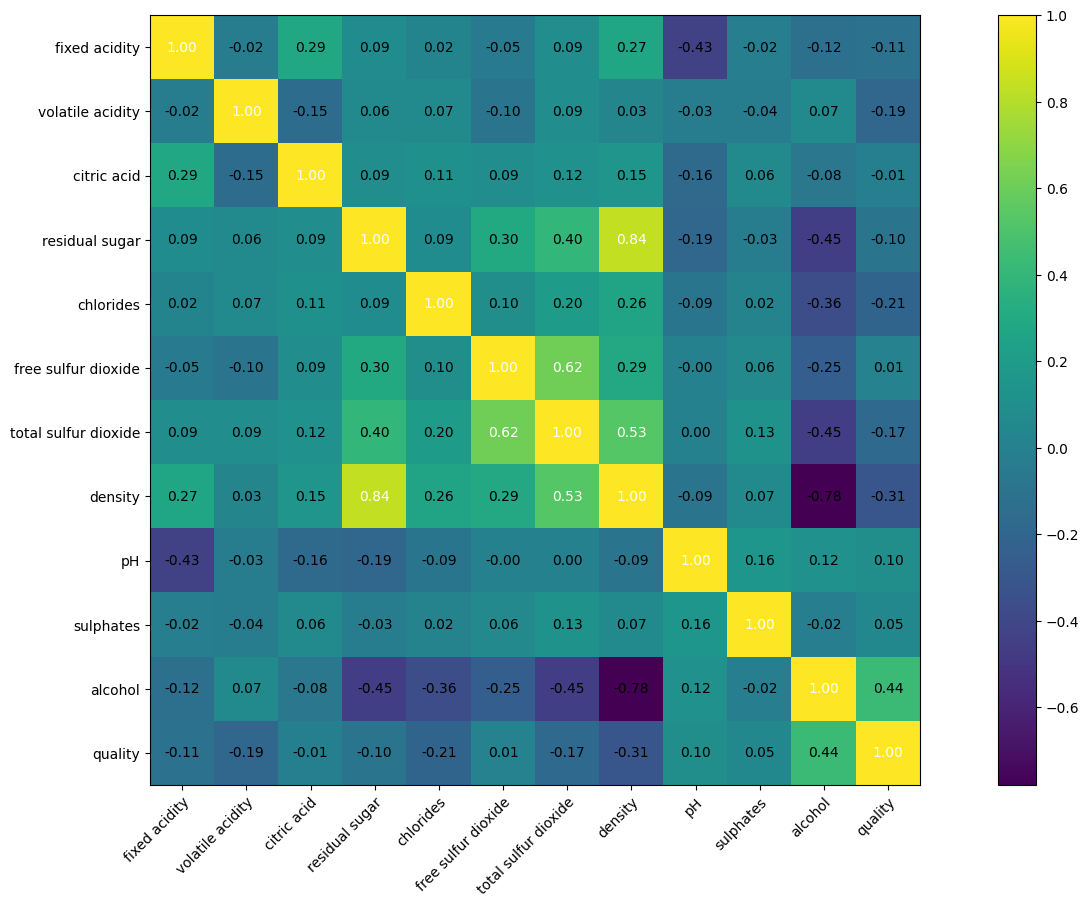

In [17]:
cm = np.corrcoef(WINE_raw_data_df[headers_list].values.T)

hm = heatmap(cm, row_names = headers_list, column_names = headers_list, figsize=(20,10))

## Process Data

In [18]:
WINE_raw_data_np = WINE_raw_data_df.to_numpy()

In [19]:
WINE_raw_data_np.shape

(4898, 12)

In [20]:
X = WINE_raw_data_np[:,:-1];
y = WINE_raw_data_np[:,11:12];

X.shape

(4898, 11)

In [21]:
y

array([[6.],
       [6.],
       [6.],
       ...,
       [6.],
       [7.],
       [6.]])

In [22]:
random_seed = int(random.random()*100)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=random_seed)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3918, 11)
(980, 11)
(3918, 1)
(980, 1)


In [25]:
y_test.dtype

dtype('float64')

In [26]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [27]:
y_test.dtype

dtype('float32')

In [28]:
X_train_tr = torch.from_numpy(X_train)
X_test_tr = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr = torch.from_numpy(y_test)

## Normalization
## Standardization

In [29]:
x_means      = X_train_tr.mean(0, keepdim=True)

x_deviations = X_train_tr.std(0, keepdim=True) + epsilon

In [30]:
x_means.shape

torch.Size([1, 11])

In [31]:
x_deviations

tensor([[8.3550e-01, 1.0124e-01, 1.1970e-01, 4.9973e+00, 2.2374e-02, 1.7076e+01,
         4.2627e+01, 3.0233e-03, 1.5132e-01, 1.1430e-01, 1.2306e+00]])

## Create Dataloader

In [32]:
train_ds = TensorDataset(X_train_tr, y_train_tr)

In [33]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

## Train Loop

In [34]:
def train_loop(N_epochs, model, loss_fn, opt):
    for epoch in range(N_epochs):
        for xb, yb in train_dl:

            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

        if epoch%20 == 0:
            print(epoch, "loss=", loss)

## Neural Network Architectures

In [35]:
## Linear Regression

class LinRegNet(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(11, 1)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means ) / self.x_deviations
        
        y_pred = self.linear1(x)
        return y_pred
        

In [36]:
class MLP_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(11, 7)
        self.act1    = nn.Sigmoid()         ## ReLU()
        self.linear2 = nn.Linear( 7 , 1 )
        self.dropout = nn.Dropout(0.25)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means ) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        y_pred = self.linear2(x)
        
        return y_pred

In [37]:
## Deep Learning with 2 hidden layers 

class DL_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(11, 9)
        self.act1    = nn.ReLU()         ## ReLU()
        self.linear2 = nn.Linear( 9 , 6 )
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear( 6, 1  )
        
        self.dropout = nn.Dropout(0.25)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means ) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        ## x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        y_pred = self.linear3(x)
        
        return y_pred

In [38]:
class LinearPlusNonLinear_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(11, 1)
        
        ## F2
        self.f2_linear1 = nn.Linear(11, 14)
        self.f2_act1    = nn.Sigmoid()
        self.f2_linear2 = nn.Linear(14, 1)
      
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means ) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_linear2(f2)
        
        y_pred = f1 + f2
     
        return y_pred

## Main Loop

In [39]:
## model = LinRegNet(x_means, x_deviations)
## model = MLP_Net(x_means, x_deviations)
## model = DL_Net(x_means, x_deviations)

model = LinearPlusNonLinear_Net(x_means, x_deviations)

opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss
train_loop(N_epochs, model, loss_fn, opt)

0 loss= tensor(38.9628, grad_fn=<MseLossBackward0>)
20 loss= tensor(44.8950, grad_fn=<MseLossBackward0>)
40 loss= tensor(36.4876, grad_fn=<MseLossBackward0>)
60 loss= tensor(39.8073, grad_fn=<MseLossBackward0>)
80 loss= tensor(42.4718, grad_fn=<MseLossBackward0>)
100 loss= tensor(34.0599, grad_fn=<MseLossBackward0>)
120 loss= tensor(37.5728, grad_fn=<MseLossBackward0>)
140 loss= tensor(43.2005, grad_fn=<MseLossBackward0>)
160 loss= tensor(41.6431, grad_fn=<MseLossBackward0>)


## Evaluate Model

In [40]:
y_pred_test = model(X_test_tr)

In [41]:
y_pred_test.shape

torch.Size([980, 1])

In [42]:
print(  "Testing R2: ", r2_score( y_test_tr.numpy(), y_pred_test.detach().numpy()  )  )

Testing R2:  -51.96625175923384


In [43]:
list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    # print("**********************************")
    # print("pred, real")
    np_real =   y_test_tr[i].detach().numpy()
    np_pred = y_pred_test[i].detach().numpy()
    # print( (np_pred[0], np_real[0])  )
    list_preds.append(  np_pred[0]   )
    list_reals.append(  np_real[0]   )

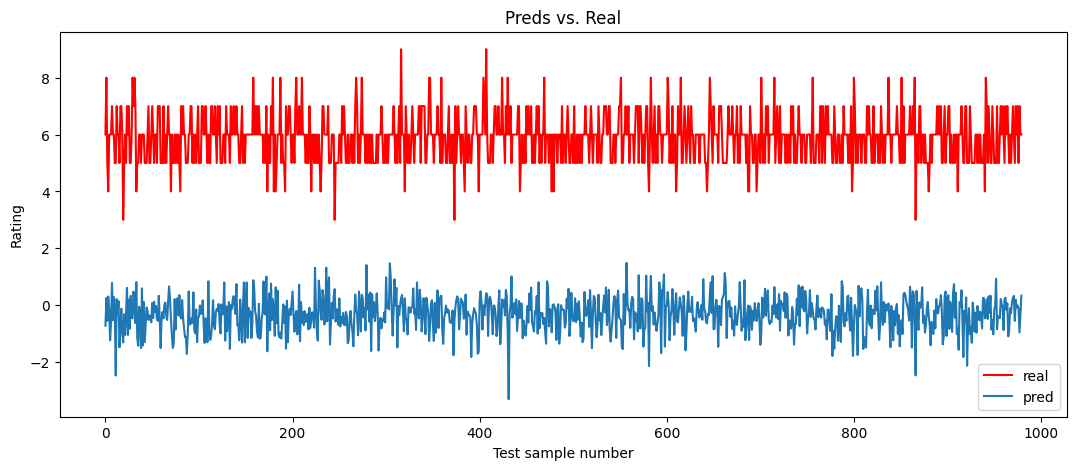

In [44]:
plt.figure(figsize=(13,5))
plt.plot(list_reals, label='real', color='r')
plt.plot(list_preds, label='pred')

plt.title("Preds vs. Real")
plt.xlabel("Test sample number")
plt.ylabel("Rating")
plt.legend()
plt.savefig("PredVsRealPlot", dpi=300)

## Deploy PyTorch Model

In [45]:
model.eval()

LinearPlusNonLinear_Net(
  (f1_linear1): Linear(in_features=11, out_features=1, bias=True)
  (f2_linear1): Linear(in_features=11, out_features=14, bias=True)
  (f2_act1): Sigmoid()
  (f2_linear2): Linear(in_features=14, out_features=1, bias=True)
)

In [46]:
dummy_input = torch.randn(1,11)
input_names = ['input1']
output_names = ['result']

In [47]:
torch.onnx.export(
    model,
    dummy_input,
    "DLnet_WineData.onnx",
    verbose=False,
    input_names = input_names,
    output_names = output_names
)

## XGBoost

In [48]:
regressor = xgb.XGBRegressor(

        n_estimators=101,
        reg_lambda=3,
        gamma=0.01,
        max_depth=7
)

In [49]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=101, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [61]:
y_test_pred = regressor.predict(X_test)

In [64]:
y_test_pred.shape

(980,)

In [65]:
r2_score(y_test, y_test_pred)

0.4658356259788863

In [66]:
from sklearn.model_selection import GridSearchCV

# Create the XGBRegressor model - regressor

# Define the hyperparameter grid for grid search
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [6, 7, 8],
    'reg_lambda': [1, 3, 5],
    'gamma': [0, 0.01, 0.1],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=4, scoring='r2', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)  # X_train and y_train should be your training data

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 5}


In [54]:
# Create an XGBRegressor with the best hyperparameters
best_xgb_reg = xgb.XGBRegressor(**best_params)

# Fit the model on the training data
best_xgb_reg.fit(X_train, y_train)

# Predict on the test data
y_pred = best_xgb_reg.predict(X_test)  # X_test should be your test data

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)  # y_test should be your test labels
print("R2 Score:", r2)

R2 Score: 0.49954593143218284


## Deploy XGBoost Model

In [55]:
initial_types = [(
    "float_input",
    FloatTensorType([None, 11])
)]

In [56]:
onnx_model = onnxmltools.convert_xgboost(regressor, initial_types=initial_types)

In [57]:
onnxmltools.utils.save_model(onnx_model, "xgboost_WineQuality_ort.onnx")

In [58]:
sess = rt.InferenceSession('xgboost_WineQuality_ort.onnx')

In [59]:
input_name = sess.get_inputs()[0].name
input_name

'float_input'

In [60]:
label_name = sess.get_outputs()[0].name
label_name

'variable'